# In this file, we will build 5-layer with wider channels neural network.

In [1]:

%matplotlib notebook

# Import Modules

In [2]:
import sys,os
#from ipynb.fs.full.secondCNN_import import *
from __future__ import unicode_literals
from glob import glob
from skimage import io
from matplotlib import style
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint as pp
from matplotlib.font_manager import FontProperties
import matplotlib
matplotlib.get_backend()
import joblib as jb
import seaborn as sns
import palettable.colorbrewer.qualitative as cbq
sns.set_palette('colorblind')
from IPython.display import SVG
from sklearn.model_selection import train_test_split
import time
import tensorflow as tf
from tqdm import tnrange, tqdm_notebook
from datetime import timedelta
import palettable.cmocean as ocean
import os
import IPython.display as display
#matplotlib.rcParams['backend'] = 'TkAgg' 
import palettable.colorbrewer as cb
from sklearn import metrics
import itertools
import numpy as np

# Helper Function

## Filename Generator

In [3]:
def gen_seq_fname(ext='pdf',count_file='count.dat',reset_count='False'):
    if reset_count =='True':
        count =0
    else:    
        count = jb.load('count.dat') 
    str1='{}.{}'.format(count,ext)
    count +=1
    jb.dump(count,'count.dat')
    return str1


## Plot Images

In [4]:
def plot_images(images, cls_true, cls_pred=None,save_fig='False'):
    fig, axes = plt.subplots(4, 4,figsize=(10,10))
    fig.subplots_adjust(hspace=0.4, wspace=0.3)
    if cls_pred is None:
        fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.ravel()):# Plot image.
        ax.imshow(images[i].reshape(48,-1), cmap='gray')
        label_color='blue'
        true_=np.argmax(cls_true[i])
        if cls_pred is None:
            xlabel = "True \U000021E8 {}".format(mod_label_dict[true_][1])
        else:
            pred_=np.argmax(cls_pred[i])
            xlabel = "{0} : {1}".\
            format(mod_label_dict[true_][1], mod_label_dict[pred_][1])
            if true_ != pred_:
                label_color='red'
        ax.set_xlabel(xlabel,color=label_color,fontname='DejaVu Sans',fontsize=20)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
    plt.tight_layout()
    if save_fig == 'True':
        f=gen_seq_fname()
        fig.savefig(f)
        print('Saved as {}'.format(f))
    

## Plot Convolution Output

In [5]:
def plot_conv_layer(layer, image):
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.

    # Create a feed-dict containing just one image.
    # Note that we don't need to feed y_true because it is
    # not used in this calculation.
    feed_dict = {x: [image]}

    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    values = session.run(layer, feed_dict=feed_dict)

    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids,figsize=(8,8))

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.ravel()):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    

## Plot Convolution Weigths

In [6]:
import math
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids,figsize=(6,6))

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap=ocean.diverging.Balance_20.mpl_colormap)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    

# CNN Model

## Import data

In [10]:
mod_images_dropD=pd.read_pickle('Data/mod_images_dropDigust.pickle')
mod_images_dropD.head()

0    1    2    3    4    5    6    7    8    9  ...    2295  2296  2297  \
0   70   80   82   72   58   58   60   63   54   58  ...     182   183   136   
1  151  150  147  155  148  133  111  140  170  174  ...     108    95   108   
2  231  212  156  164  174  138  161  173  182  200  ...     138   152   122   
3   24   32   36   30   32   23   19   20   30   41  ...     126   132   132   
4    4    0    0    0    0    0    0    0    0    0  ...      34    31    31   

   2298  2299  2300  2301  2302  2303  label  
0   106   116    95   106   109    82      0  
1   102    67   171   193   183   184      0  
2   114   101    97    88   110   152      2  
3   133   136   139   142   143   142      4  
4    31    27    31    30    29    30      6  

[5 rows x 2305 columns]

## Label Dictionary

In [11]:
#label_dict={0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
# label_dict={0:['Angry',u'\U0001f620'],1:['Disgust',u'\U0001f641'],2:['Fear',u'\U0001f628'],\
#             3:['Happy',u'\U0001f604'],4:['Sad',u'\U0001f622'],5:['Surprise',u'\U0001f632'],\
#             6:['Neutral',u'\U0001f610']}
label_dict={0: ['Angry', '😠'],
 1: ['Disgust', '🙁'],
 2: ['Fear', '😨'],
 3: ['Happy', '😄'],
 4: ['Sad', '😢'],
 5: ['Surprise', '😲'],
 6: ['Neutral', '😐']}

mod_label_dict={0:['Angry',u'\U0001f620'],1:['Fear',u'\U0001f628'],\
            2:['Happy',u'\U0001f604'],3:['Sad',u'\U0001f622'],4:['Surprise',u'\U0001f632'],\
            5:['Neutral',u'\U0001f610']}


## Train, Validation & Test Dataset

In [12]:
train, test = train_test_split(mod_images_dropD, test_size = 0.3,\
                                stratify=mod_images_dropD.label.values)
# print(train.label.value_counts())
# print(test.label.value_counts())
test, validation = train_test_split(test, test_size = 0.5,\
                                stratify=test.label.values)

print(test.label.value_counts())
print(validation.label.value_counts())

test_y=pd.get_dummies(test['label']).values
validation_y=pd.get_dummies(validation['label']).values
train_y=pd.get_dummies(train['label']).values

train_x=train.iloc[:,:2304].values
validation_x=validation.iloc[:,:2304].values
test_x=test.iloc[:,:2304].values

4    3
3    3
2    3
6    2
5    2
0    2
Name: label, dtype: int64
6    3
3    3
0    3
5    2
4    2
2    2
Name: label, dtype: int64


## Data Dimension

In [13]:
image_size=48
image_size_flat=image_size*image_size
image_shape=(image_size,image_size)
# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1
num_classes = 6

## Convolutional Network Architecture

In [14]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 32         # There are 32 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 64         # There are 36 of these filters.
# Convolutional Layer 3.
filter_size3 = 5          # Convolution filters are 5 x 5 pixels.
num_filters3 = 64         # There are 36 of these filters.

# Fully-connected layer.
dc_size = 128   

## Generate weights and biases 

In [15]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

## Create Convolutional Layer

In [16]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

## Flatten Layers for Densely Connected Layers

In [17]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

## Densely Connected Layers

In [18]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 dropout,        # Dropout to prevent overfitting
                 use_relu=True,  # Use Rectified Linear Unit (ReLU)?
                 use_dropout=True):

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)
        
    if use_dropout:
        layer=tf.nn.dropout(layer,dropout)

    return layer

## Placeholder variables

In [19]:
tf.reset_default_graph()
x = tf.placeholder("float", shape=[None, image_size_flat],\
                   name='x')
image_x = tf.reshape(x, \
                   [-1,image_size,image_size,\
                    num_channels])
y=tf.placeholder("float",\
                      shape=[None,num_classes],\
                       name='y')

dropout = tf.placeholder("float",name='dropout')

tf.add_to_collection('vars', x)
tf.add_to_collection('vars', y)
tf.add_to_collection('vars', dropout)

## Convolutional Layer 1

In [20]:
#tf.reset_default_graph()
L1_conv, W1_conv=\
new_conv_layer(input = image_x,\
               num_input_channels=num_channels,\
               filter_size=filter_size1,
               num_filters=num_filters1,
               use_pooling=True)

print(L1_conv)
print(W1_conv)

Tensor("Relu:0", shape=(?, 24, 24, 32), dtype=float32)
<tf.Variable 'Variable:0' shape=(5, 5, 1, 32) dtype=float32_ref>


## Convolutional Layer 2

In [21]:
L2_conv, W2_conv=\
new_conv_layer(input = L1_conv,\
               num_input_channels=num_filters1,\
               filter_size=filter_size2,
               num_filters=num_filters2,
               use_pooling=True)

print(L2_conv)
print(W2_conv)

Tensor("Relu_1:0", shape=(?, 12, 12, 64), dtype=float32)
<tf.Variable 'Variable_2:0' shape=(5, 5, 32, 64) dtype=float32_ref>


## Convolutional Layer 3

In [22]:
L3_conv, W3_conv=\
new_conv_layer(input = L2_conv,\
               num_input_channels=num_filters2,\
               filter_size=filter_size3,
               num_filters=num_filters3,
               use_pooling=True)

print(L3_conv)
print(W3_conv)

Tensor("Relu_2:0", shape=(?, 6, 6, 64), dtype=float32)
<tf.Variable 'Variable_4:0' shape=(5, 5, 64, 64) dtype=float32_ref>


## Prepare for Densely Connected Layer [ Flatten Input For DL]

In [23]:
L_flat, num_features = flatten_layer(L2_conv)
print(L_flat)
print(num_features)

Tensor("Reshape_1:0", shape=(?, 9216), dtype=float32)
9216


## Densely Connected Layer 1

In [24]:
L1_dc = new_fc_layer(input=L_flat,
                         num_inputs=num_features,
                         num_outputs=128,
                         dropout = dropout,
                         use_relu=True)
L1_dc

<tf.Tensor 'dropout_1/mul:0' shape=(?, 128) dtype=float32>

## Densely Connected Layer 2

In [25]:
L2_dc = new_fc_layer(input=L1_dc,
                         num_inputs=128,
                         num_outputs=num_classes,
                         dropout=dropout,
                         use_relu=False)
L2_dc

<tf.Tensor 'dropout_2/mul:0' shape=(?, 6) dtype=float32>

## Prediction 

In [26]:
y_pred=tf.nn.softmax(L2_dc)
print(y_pred)

Tensor("Softmax:0", shape=(?, 6), dtype=float32)


In [27]:
y_pred_val=tf.argmax(y_pred,dimension=1)
print(y_pred_val)

Tensor("ArgMax:0", shape=(?,), dtype=int64)


## Cost-Function For Optimization

In [28]:
beta=0.0001
cross_entropy = \
tf.nn.softmax_cross_entropy_with_logits(\
                                        logits=L2_dc,
                                        labels=y)+\
beta*tf.nn.l2_loss(W1_conv) +\
beta*tf.nn.l2_loss(W2_conv) + \
beta*tf.nn.l2_loss(W3_conv)

cost=tf.reduce_mean(cross_entropy)

In [29]:
#optimizer = tf.train.AdamOptimizer(\
#                                   learning_rate=1e-4).minimize(cost)
optimizer=tf.train.RMSPropOptimizer(learning_rate=0.001, decay=0.9).minimize(cost)

In [30]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])
print('Test accuracy for test_y vs. test_y = {:.2f}% '.format(accuracy(test_y,test_y)))

Test accuracy for test_y vs. test_y = 100.00% 


## TensorFlow Session



In [31]:
session = tf.Session()
saver = tf.train.Saver(max_to_keep=10000)

### Initialize variables


In [40]:
session.run(tf.global_variables_initializer())

In [41]:
batch_size=10
total_iterations=0
inc=0
result_dict={'Minibatch accuracy':[],'Validation accuracy':[],\
             'Minibatch loss':[],'test_score':[]}
def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations,result_dict,inc
    total_iterations += num_iterations
    # Start-time used for printing time-usage below.
    start_time = time.time()

#     for i in range(total_iterations,
#                    total_iterations + num_iterations):
    fig,ax = plt.subplots(1,4,figsize=(12,4))
    ax=ax.ravel()
    fig.show()
    #
    
    
    #####
    ##### 'b' is for random shuffle index. 
    b=np.arange(len(train_x))
    
    batch_list=list(zip(\
                   range(0, len(train_x), batch_size),\
                   range(batch_size, len(train_x)+1, batch_size)))
    N=len(list(batch_list))
    #print(list(batch_list),N)
    full_loop=num_iterations//N if num_iterations%N == 0 else 1+num_iterations//N
    
    #writer = tf.summary.FileWriter('logs', sess.graph)
    stop_loop=False
    for step in tnrange(full_loop,desc="Progress"):
        if stop_loop:
            break
        np.random.shuffle(b)
        for count,(start, end) in enumerate(batch_list):
            index=b[start:end]
            inc +=1
            if num_iterations ==0:
                stop_loop=True
                break
            

        
            feed_dict_train={x: train_x[index], y: train_y[index],dropout:0.7}
            #print(feed_dict_train)
            _,l,predictions=session.run([optimizer,cost,y_pred], feed_dict=feed_dict_train)

    
            if (count % 10 == 0 ):
            # Calculate the accuracy on the training-set.
                #acc = session.run(accuracy, feed_dict=feed_dict_)
                feed_dict_valid={x: validation_x,dropout:1}
                valid_predict=session.run(y_pred, feed_dict=feed_dict_valid)
    #             # Message for printing.
    #             msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

    #             # Print it.
    #             print(msg.format(i + 1, acc))
                result_dict['Minibatch accuracy'].append(accuracy(predictions, train_y[index]))
                #result_dict['count'].append(inc*100)
                result_dict['Minibatch loss'].append(l)
                result_dict['Validation accuracy'].append(accuracy(valid_predict, validation_y))
                
                inc += 1
                for num,key in enumerate(result_dict.keys()):
                    ax[num].clear()
                    #ax[num].grid(False)
                    resulty=result_dict[key]
                    ax[num].plot(np.arange(len(resulty))*batch_size,resulty,'r.-',markersize=12)
                    ax[num].set_title(key)
                fig.canvas.draw()
                
            num_iterations = num_iterations -1
    
    

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time
    
    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
    print("Iteration: "+str(total_iterations))

<IPython.core.display.Javascript object>


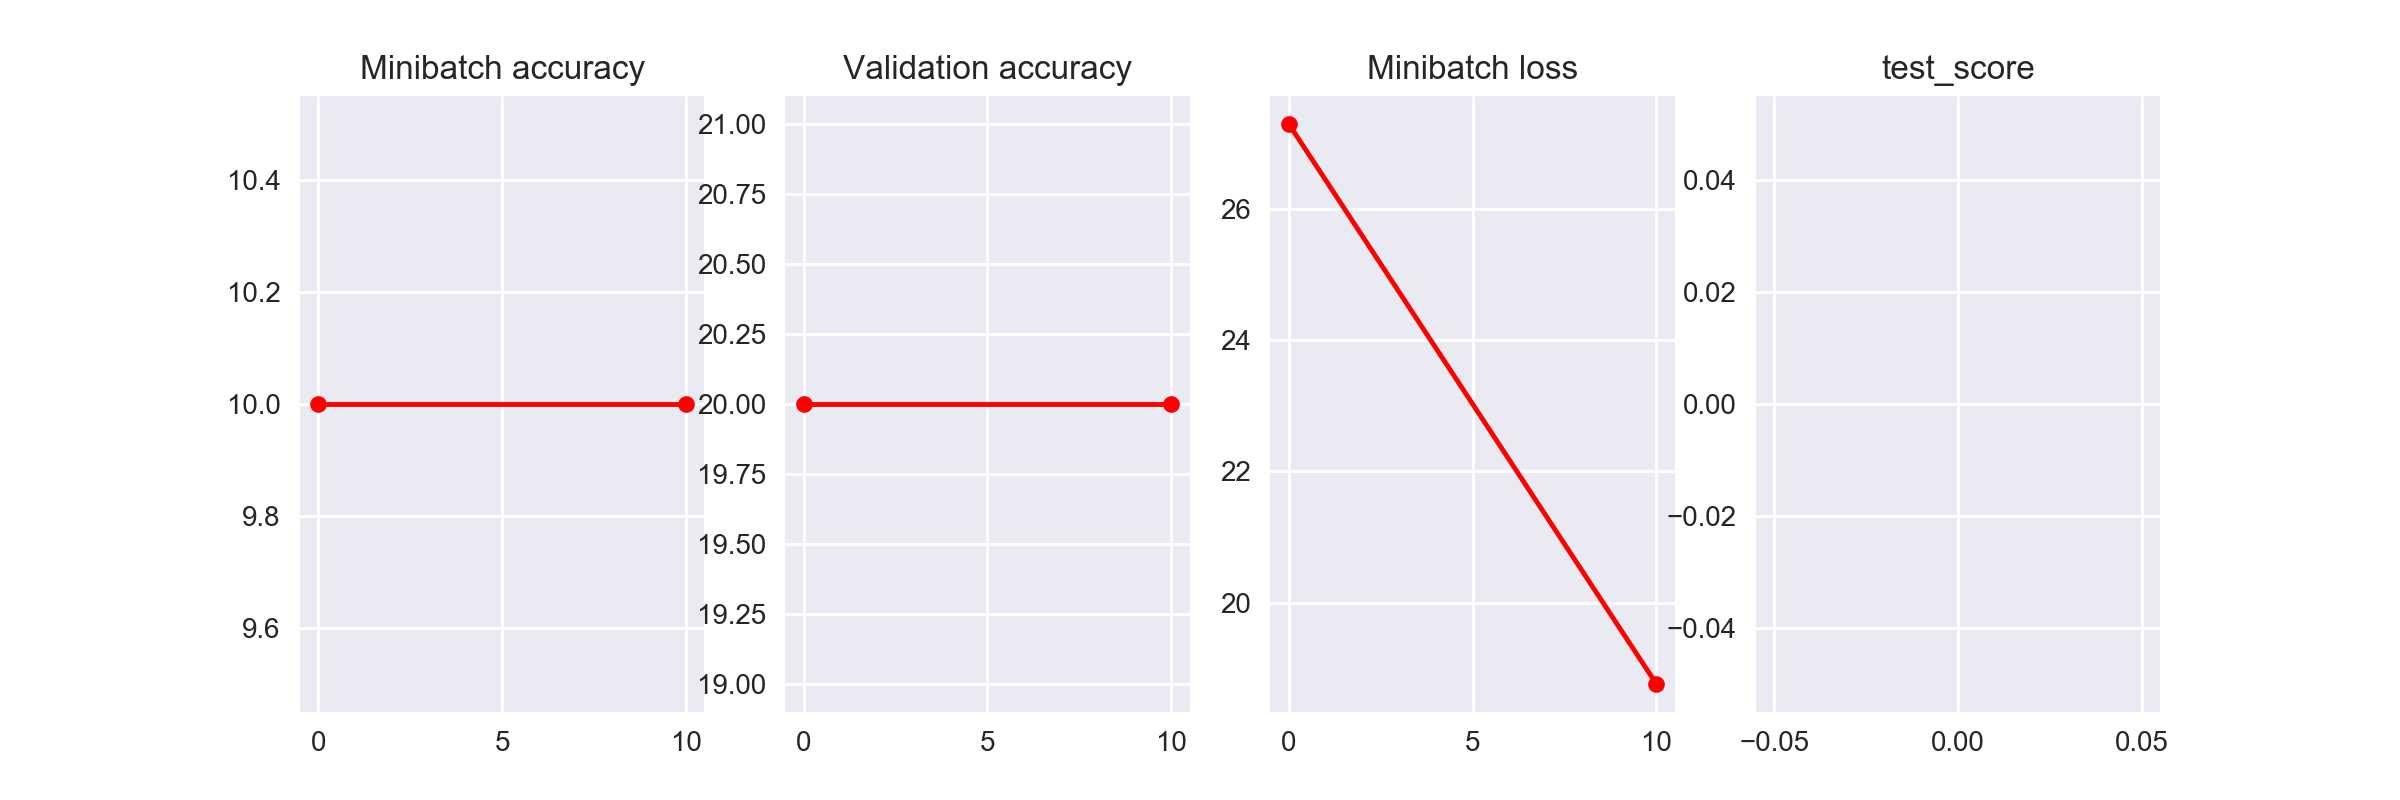


Time usage: 0:00:01
Iteration: 10


<IPython.core.display.Javascript object>


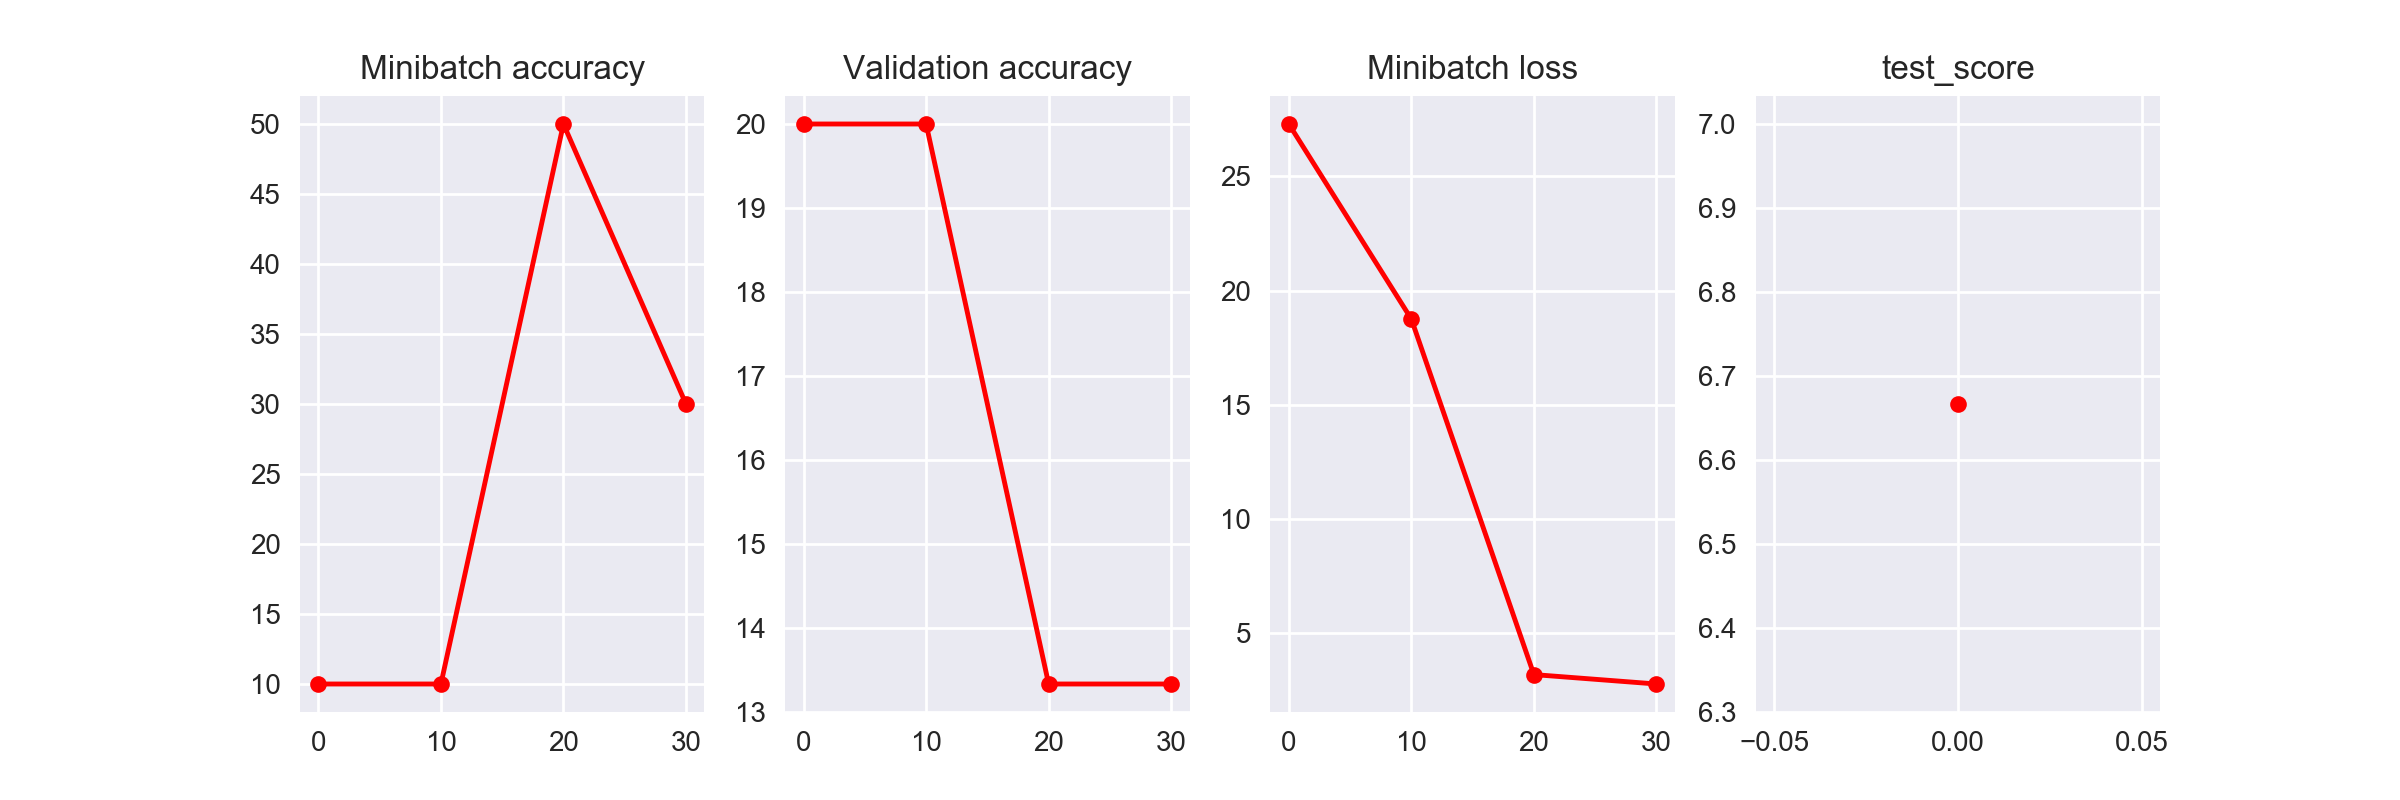


Time usage: 0:00:01
Iteration: 20


<IPython.core.display.Javascript object>


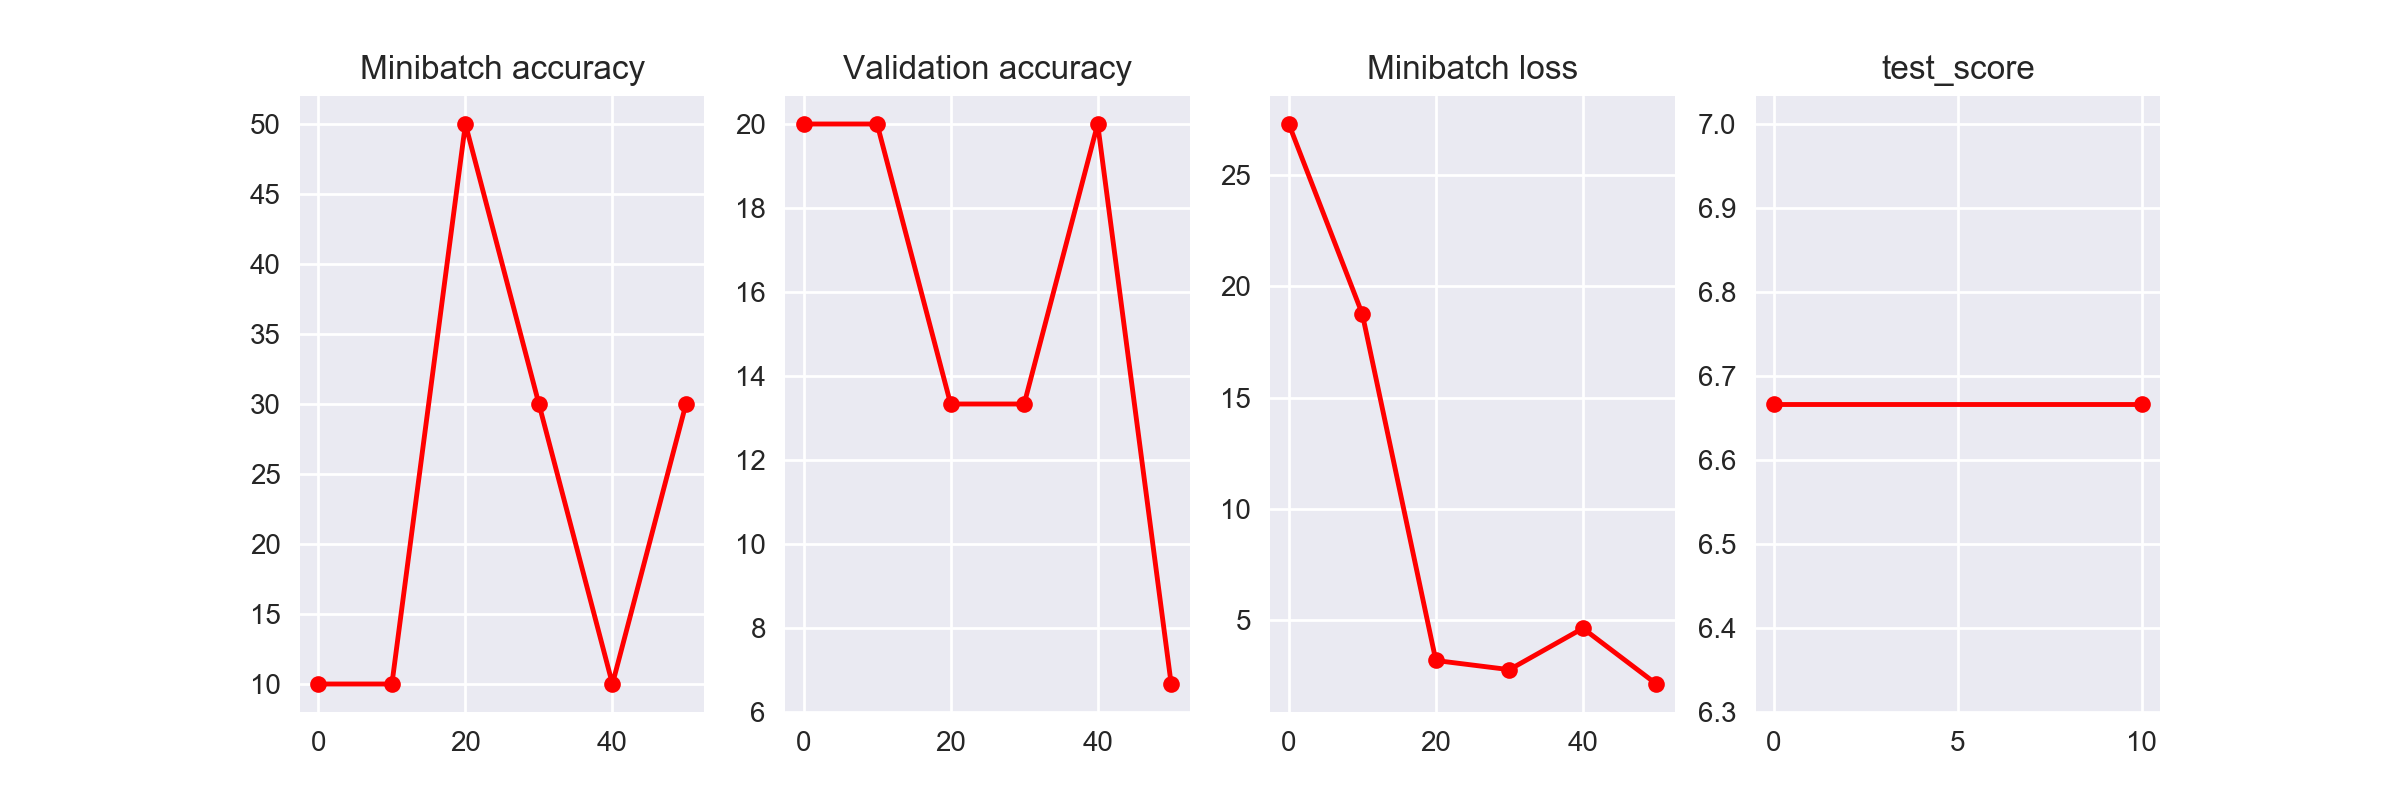


Time usage: 0:00:01
Iteration: 30


<IPython.core.display.Javascript object>


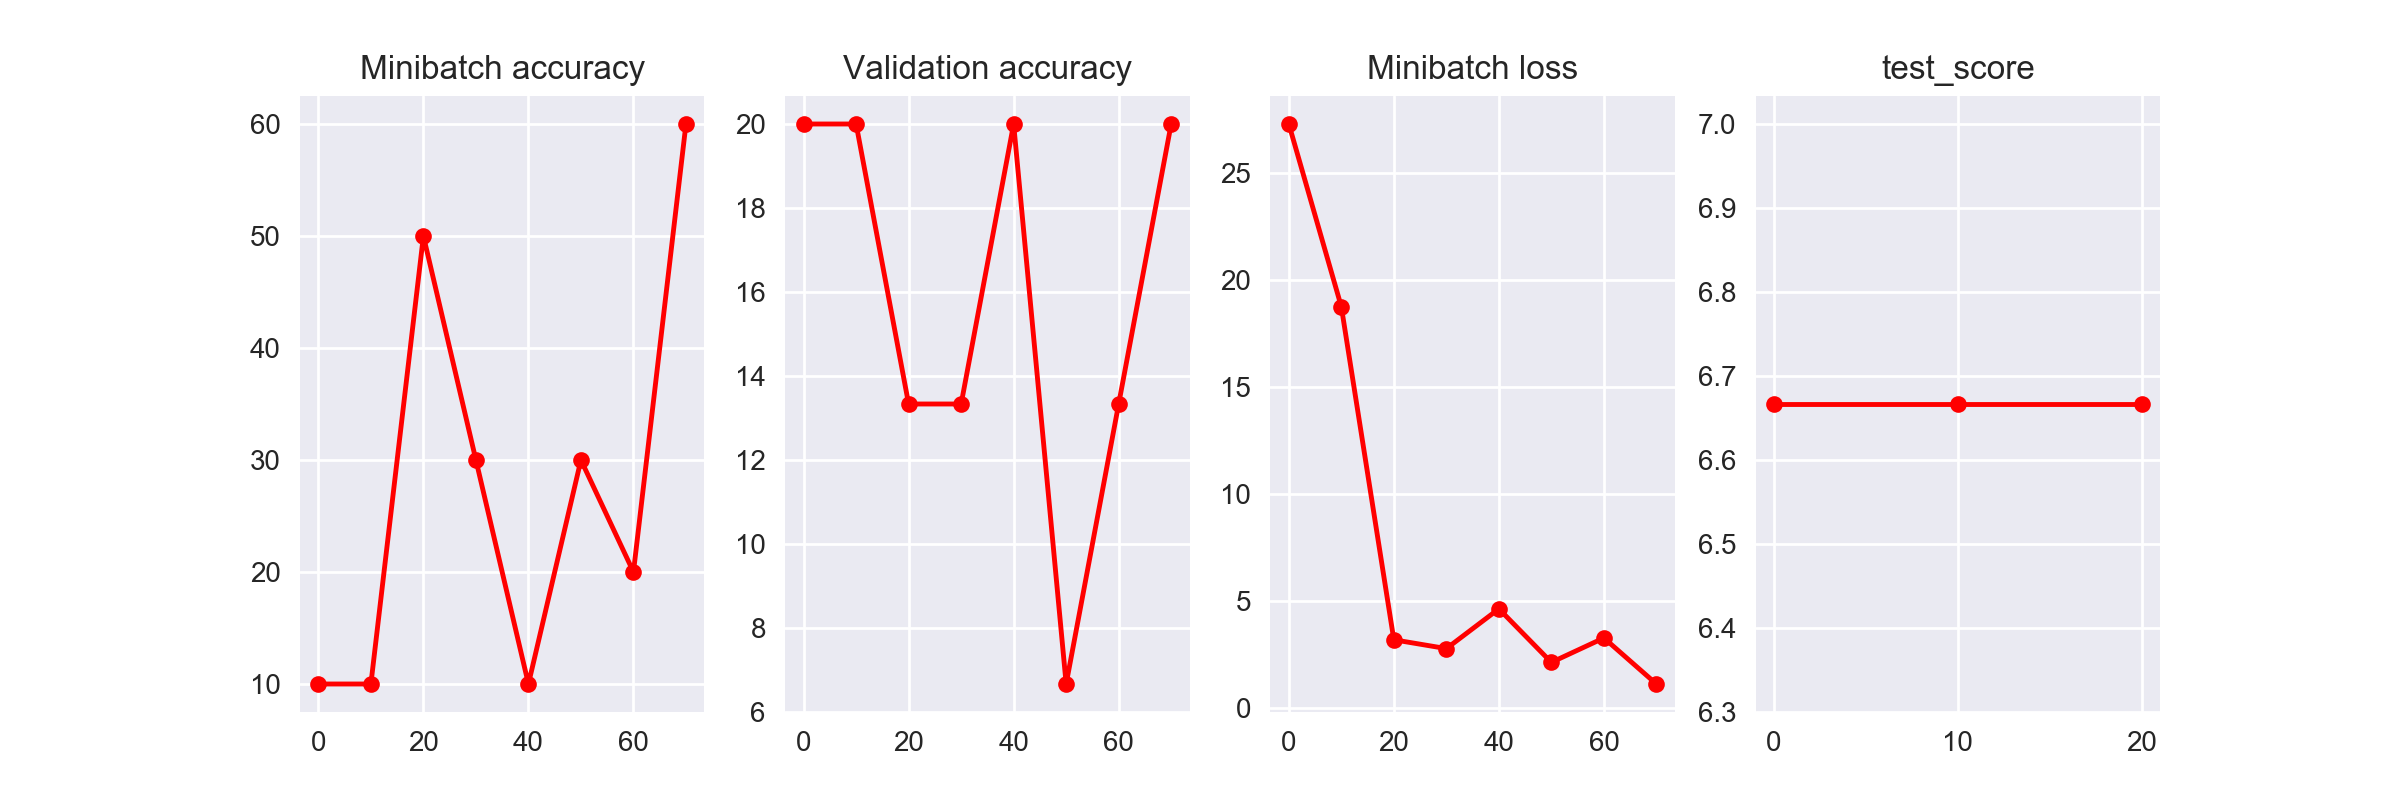


Time usage: 0:00:01
Iteration: 40


<IPython.core.display.Javascript object>


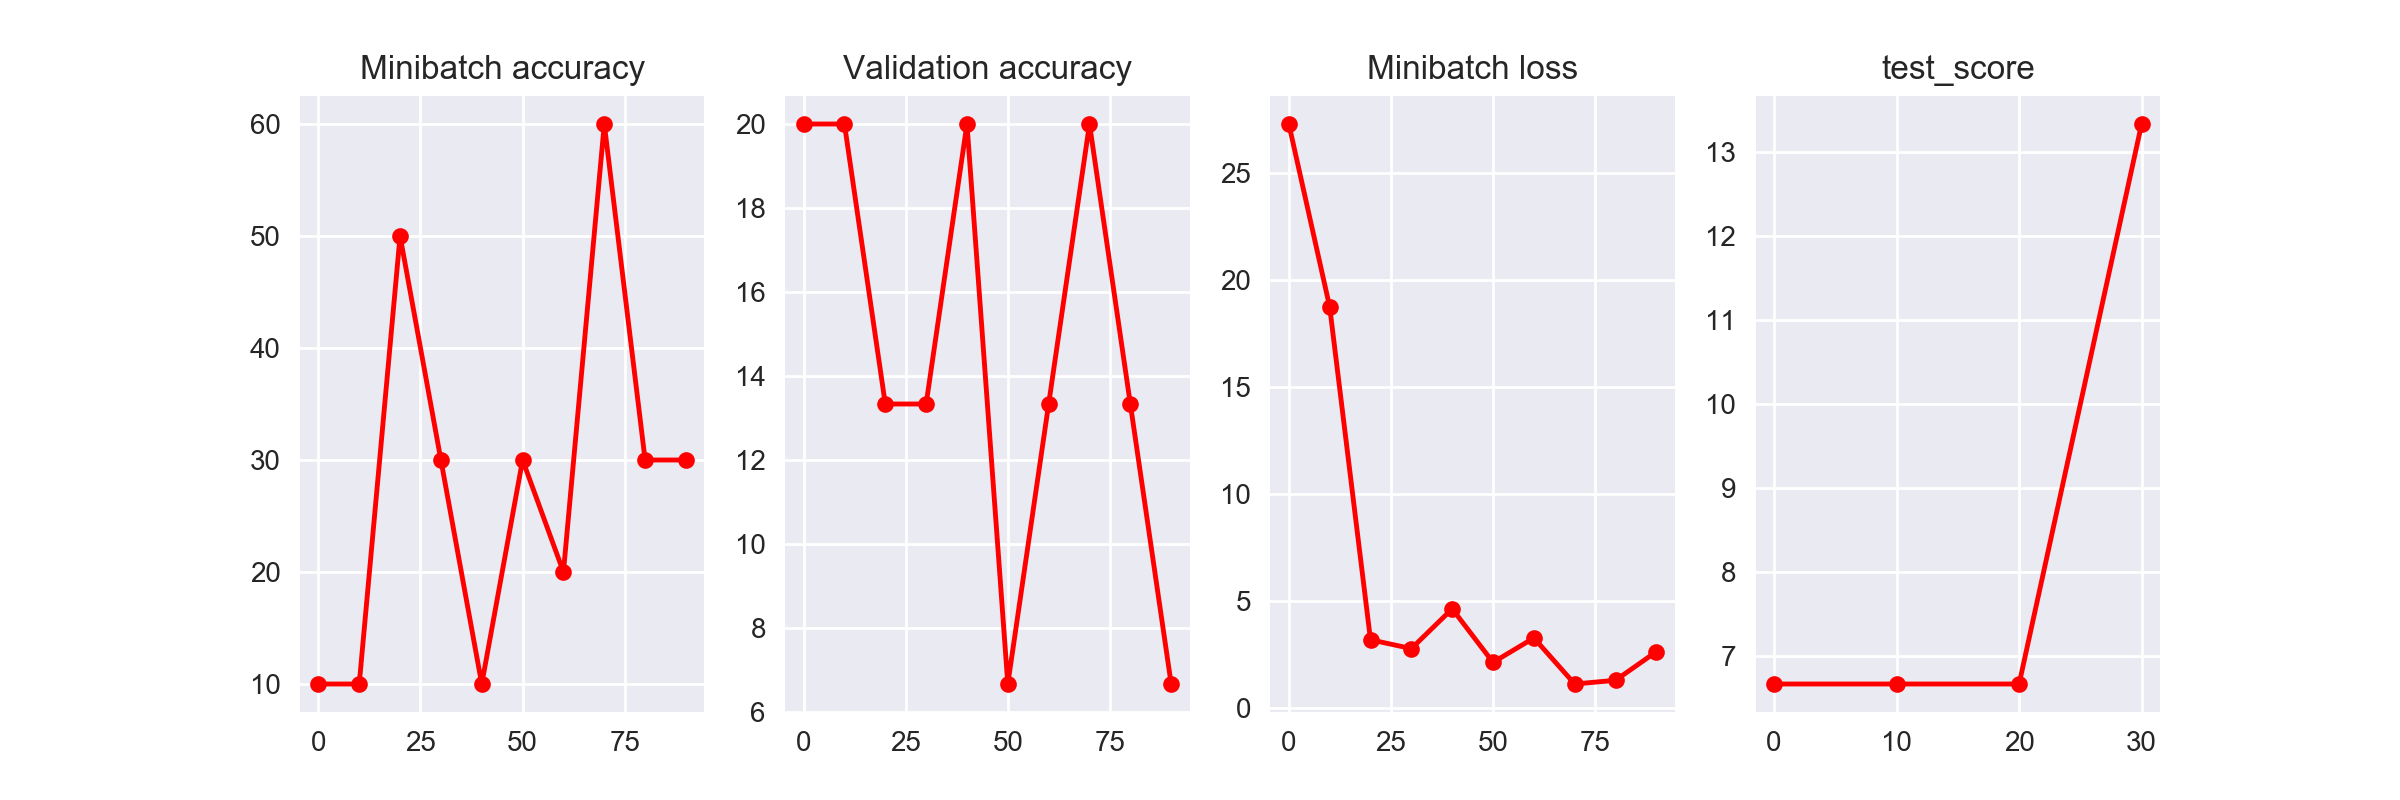


Time usage: 0:00:01
Iteration: 50


<IPython.core.display.Javascript object>


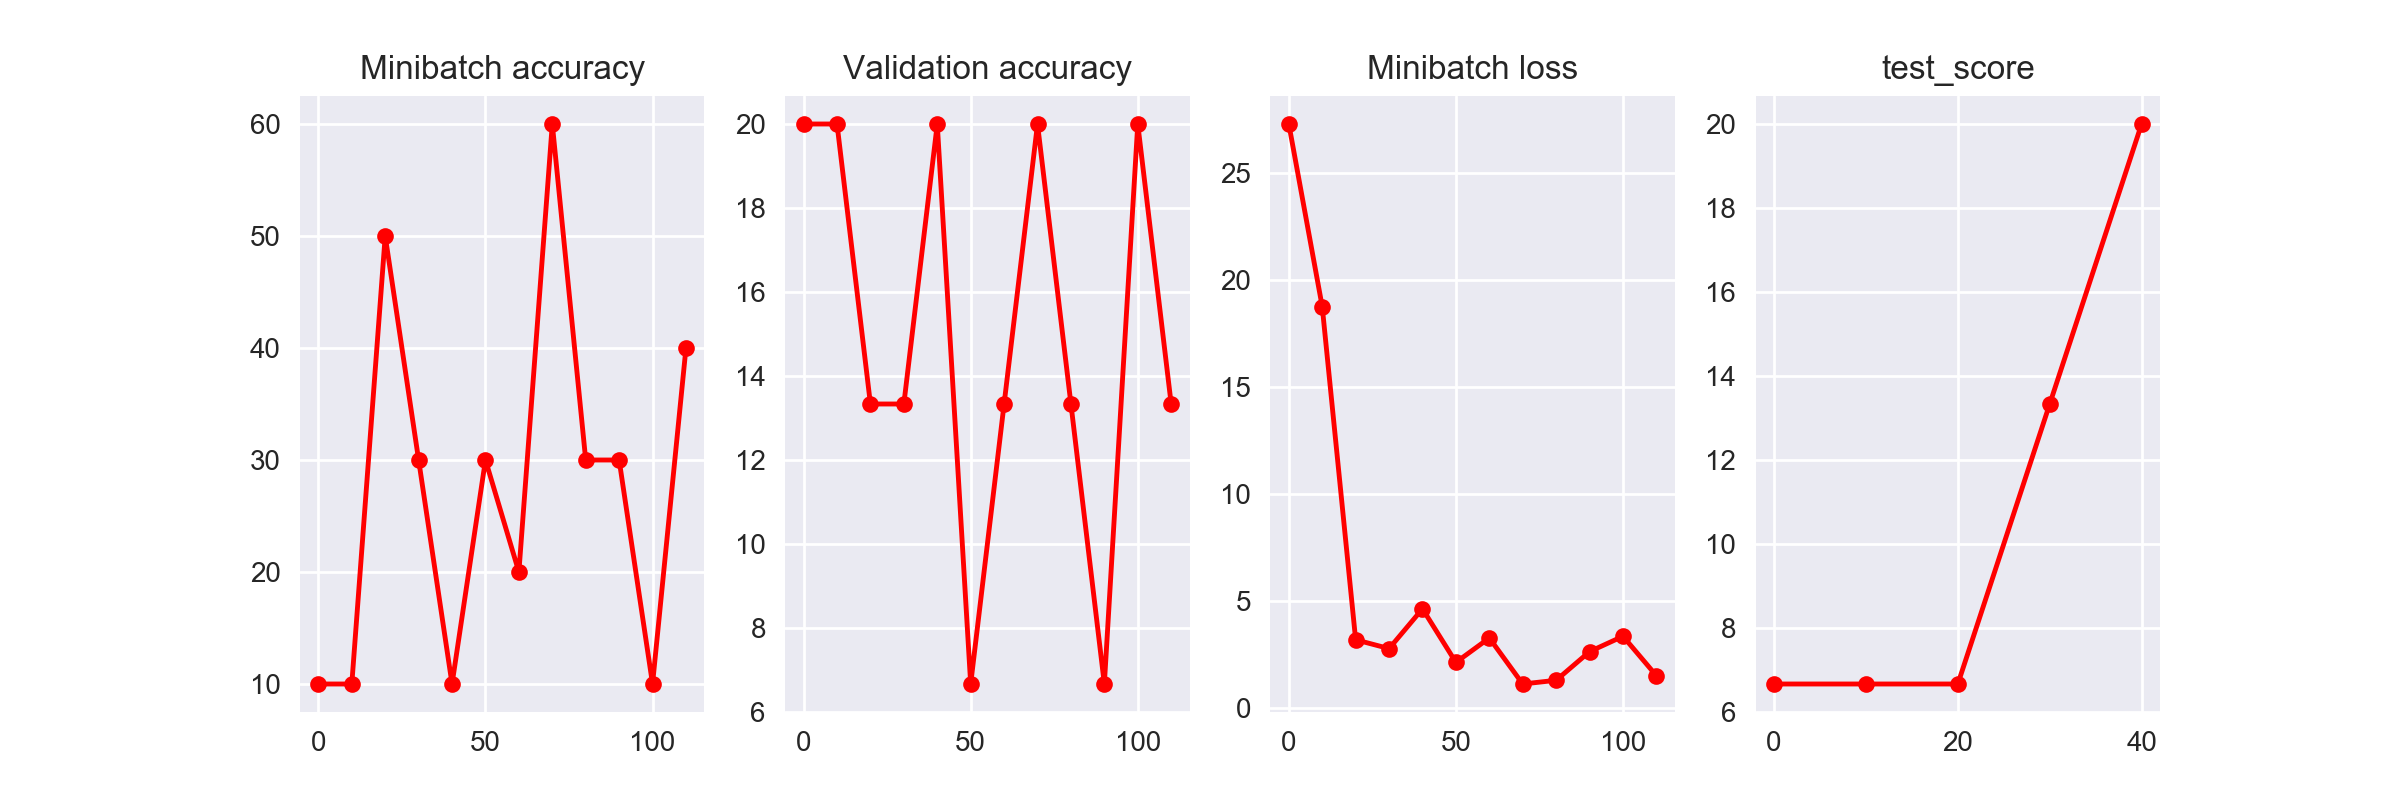


Time usage: 0:00:01
Iteration: 60


<IPython.core.display.Javascript object>


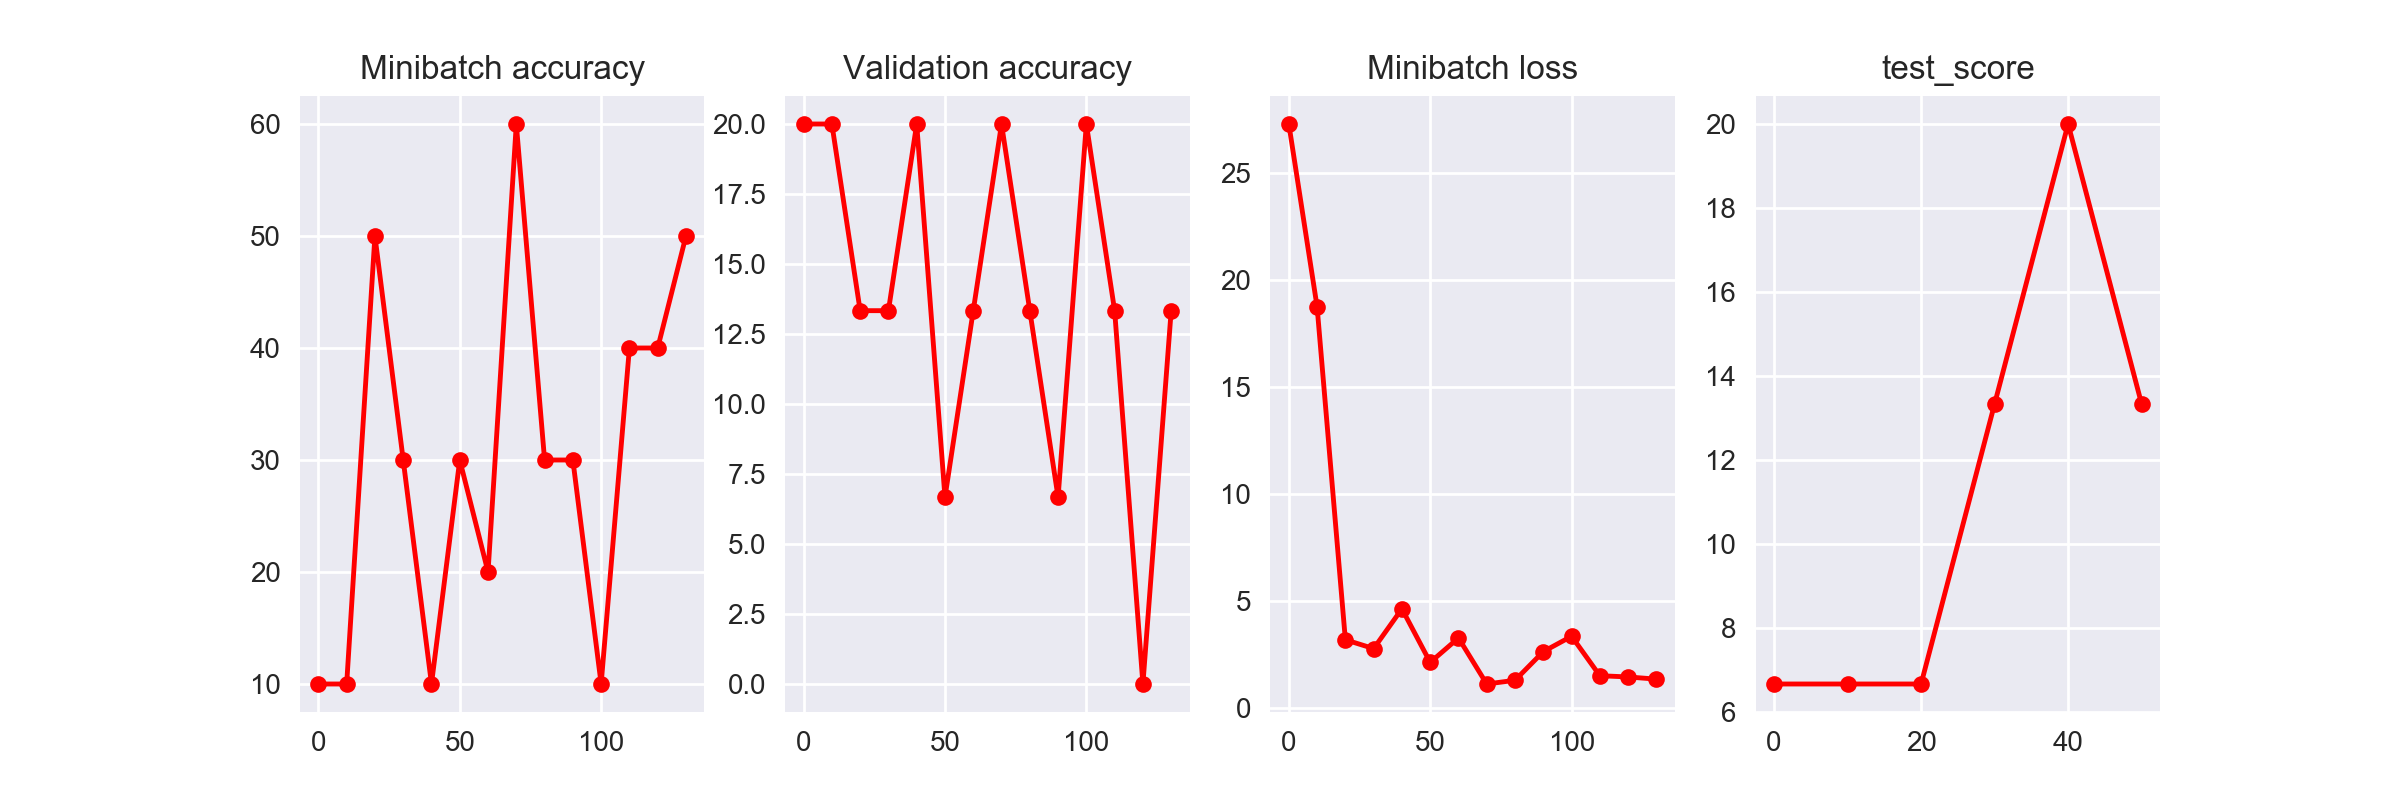


Time usage: 0:00:01
Iteration: 70


<IPython.core.display.Javascript object>


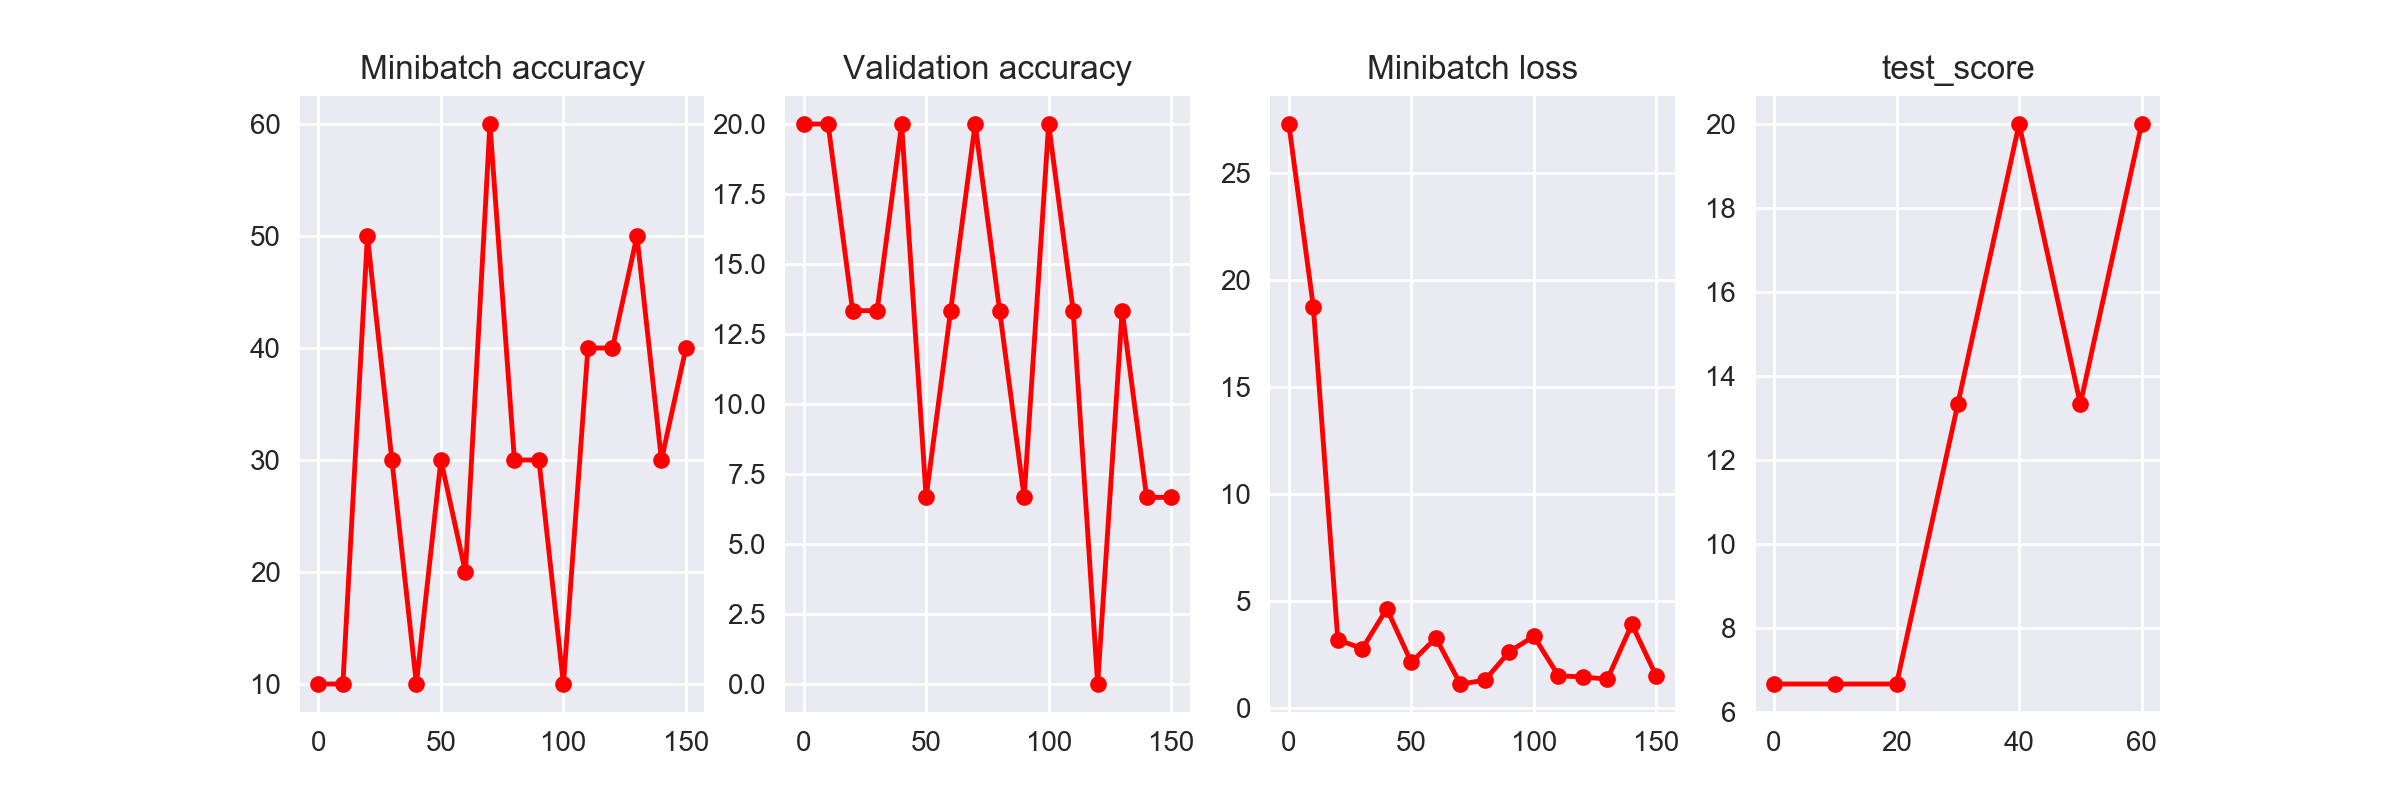


Time usage: 0:00:01
Iteration: 80


<IPython.core.display.Javascript object>


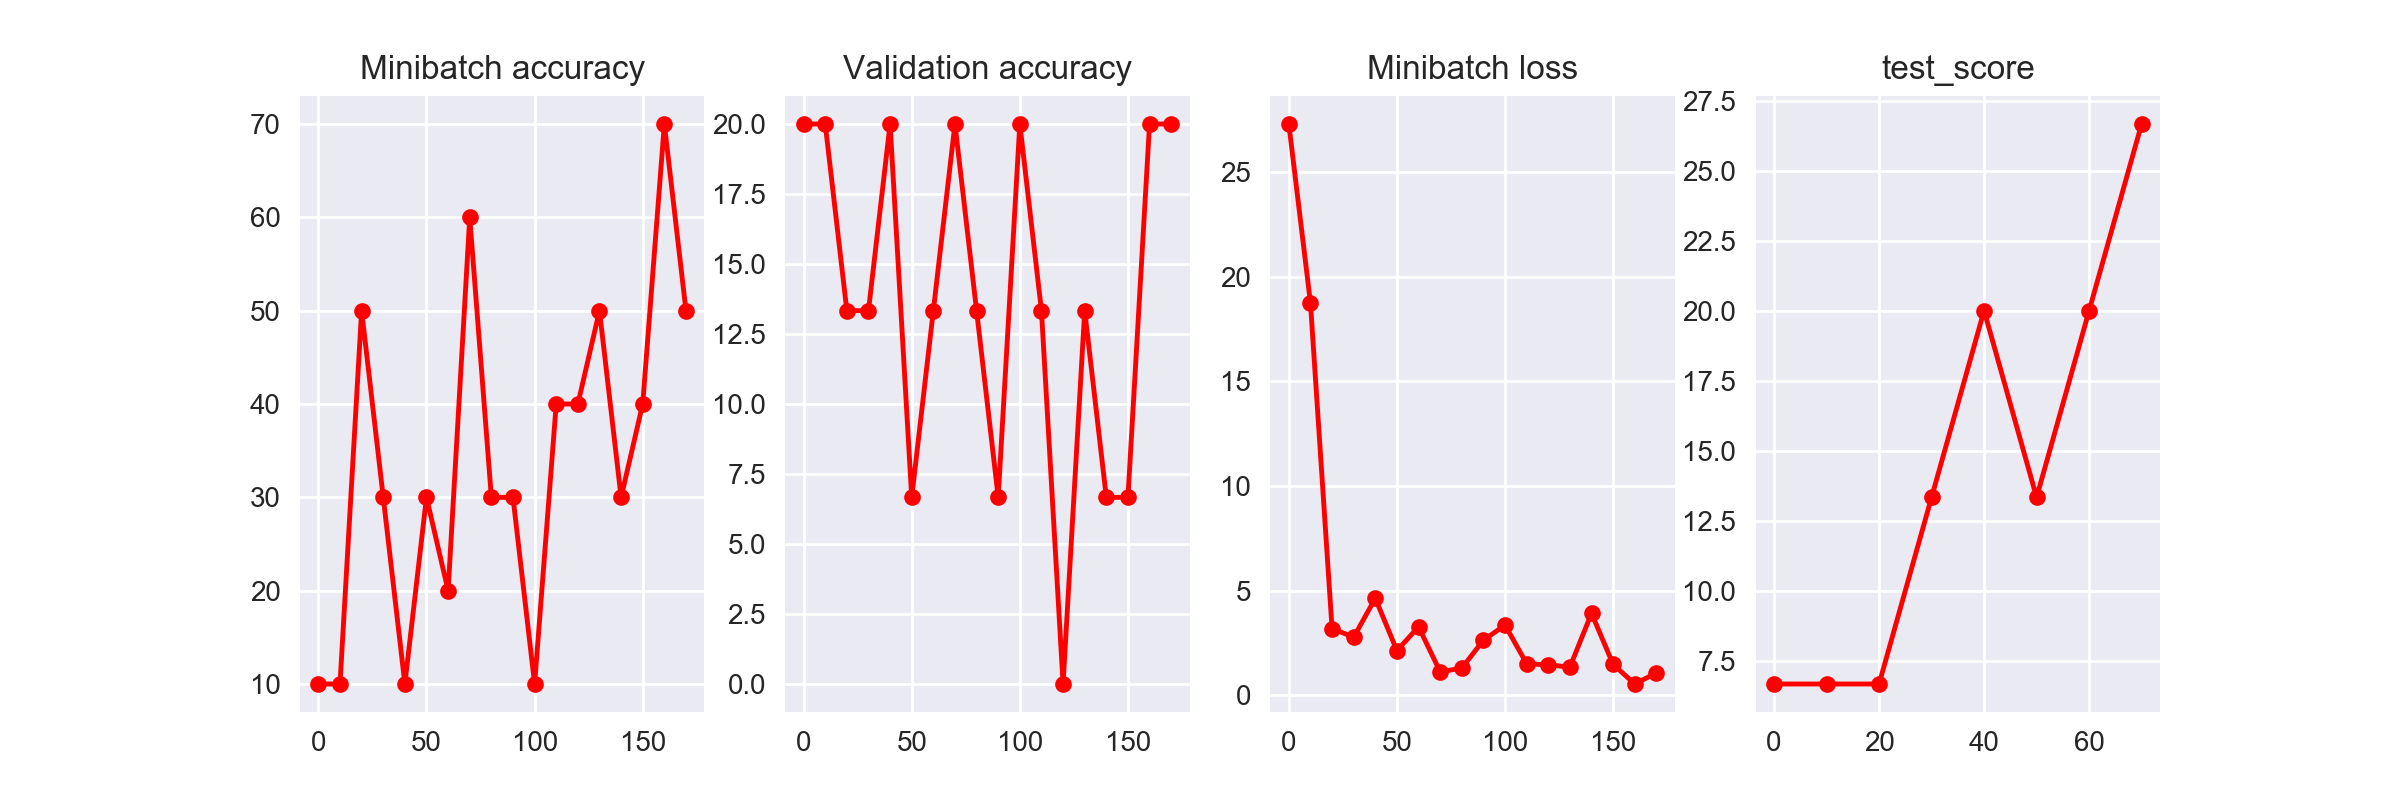


Time usage: 0:00:01
Iteration: 90


<IPython.core.display.Javascript object>


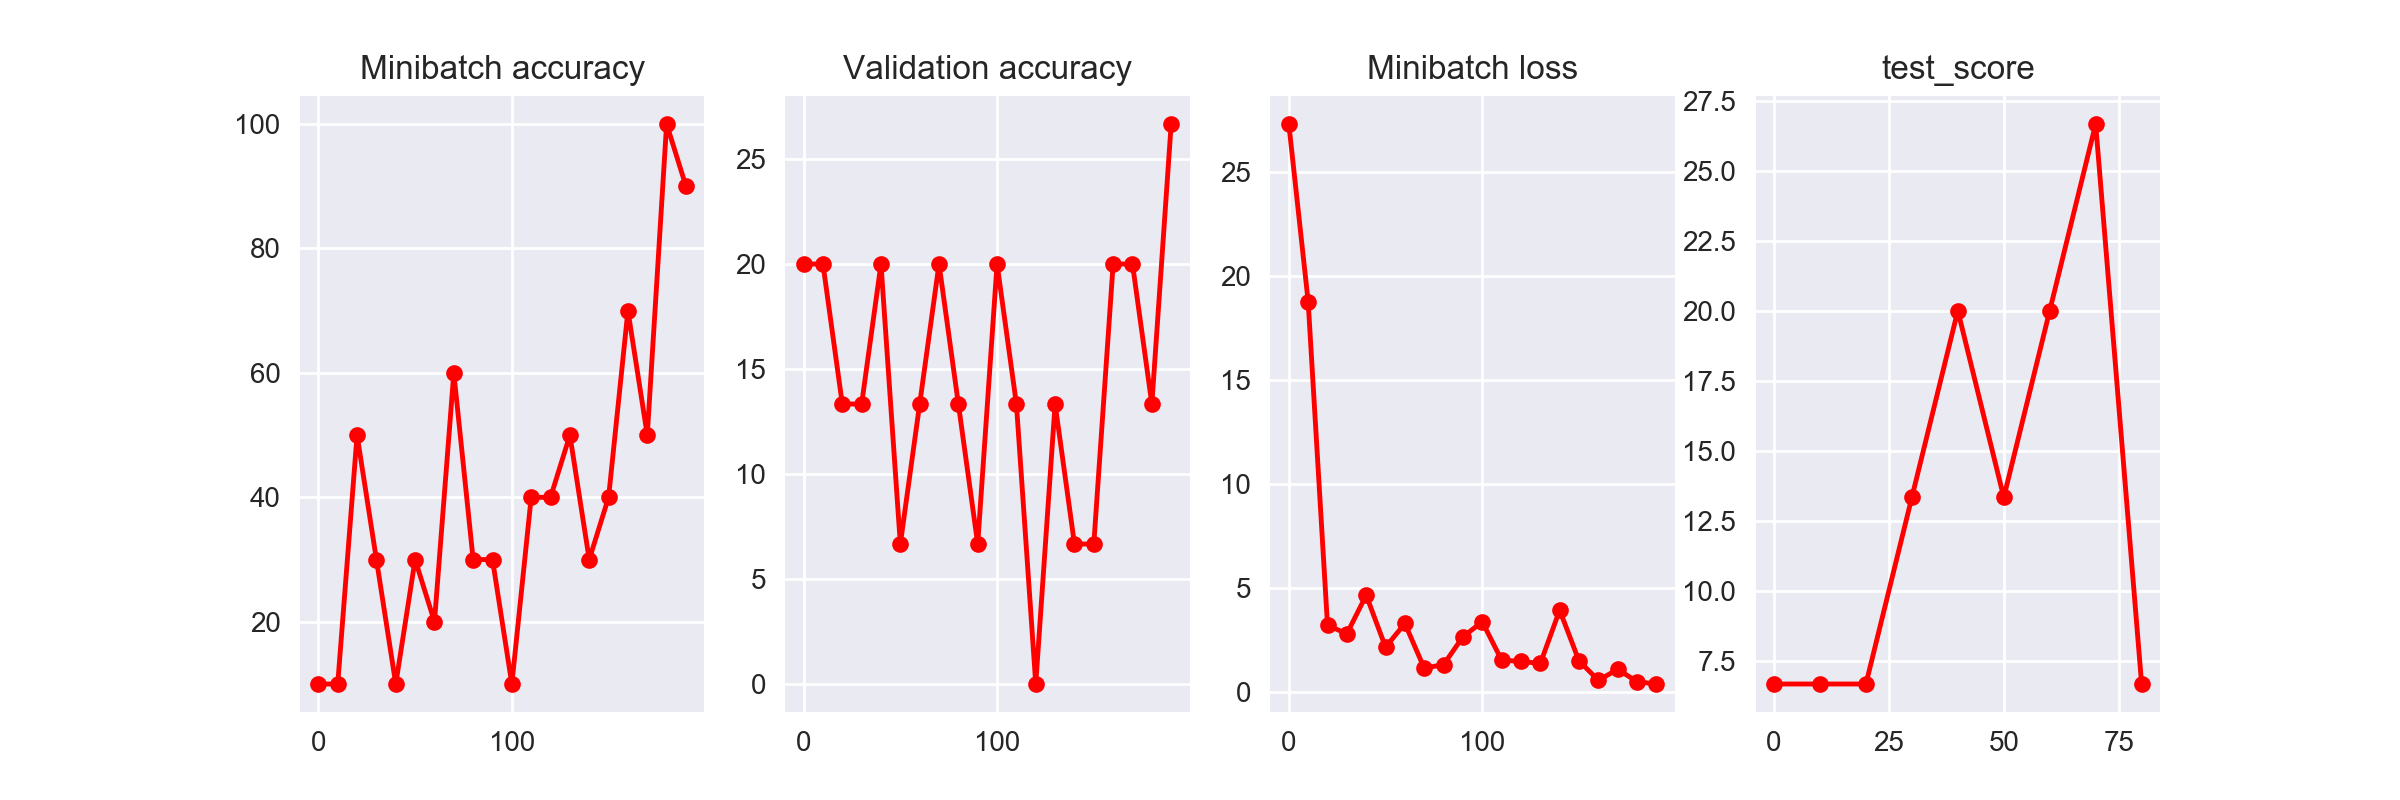


Time usage: 0:00:01
Iteration: 100


In [42]:
for i in range(10):
    optimize(num_iterations=10)
    test_predict=session.run(y_pred, feed_dict={x: test_x,dropout:1})
    xx=accuracy(test_predict,test_y)
    score=np.round(xx*100)
    result_dict['test_score'].append(xx)
    fname='2stmodel_{}_{}'.format(inc,score)
    jb.dump(result_dict,'2ndmodel_checkpoints_2/result_dict_'+fname+'.pkl')
    saver.save(sess=session, save_path='2ndmodel_checkpoints_2/'+fname)

In [43]:
def plot_confusion_matrix(predictions, y_test,classes,
                          normalize=False,
                          title='Confusion matrix',
                          #cmap=cb.diverging.RdYlBu_11_r.mpl_colormap):
                          cmap=cb.sequential.YlGn_9.mpl_colormap):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    # Compute confusion matrix
    predictions=np.argmax(predictions,1)
    y_test=np.argmax(y_test,1)
    cm = metrics.confusion_matrix(y_test, predictions)
    np.set_printoptions(precision=2)
    fig, ax1 = plt.subplots()    
    
    if normalize:
        np.set_printoptions(precision=2)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        p=ax1.imshow(cm, interpolation='nearest', cmap=cmap)
        print("Normalized confusion matrix")
        cm=np.round(cm,2)
    else:
        p=ax1.imshow(cm, interpolation='nearest', cmap=cmap)
        print('Confusion matrix, without normalization')
        
    
    
    plt.title(title)
    plt.colorbar(p)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    
    
    #print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)




In [44]:
# result_dict=jb.load('2ndmodel_checkpoints_2/result_dict_2stmodel_17344_6306.0.pkl')
# np.mean(np.array(result_dict['test_score'])[2:12])

In [45]:
length=len(result_dict['Minibatch accuracy'])

<IPython.core.display.Javascript object>


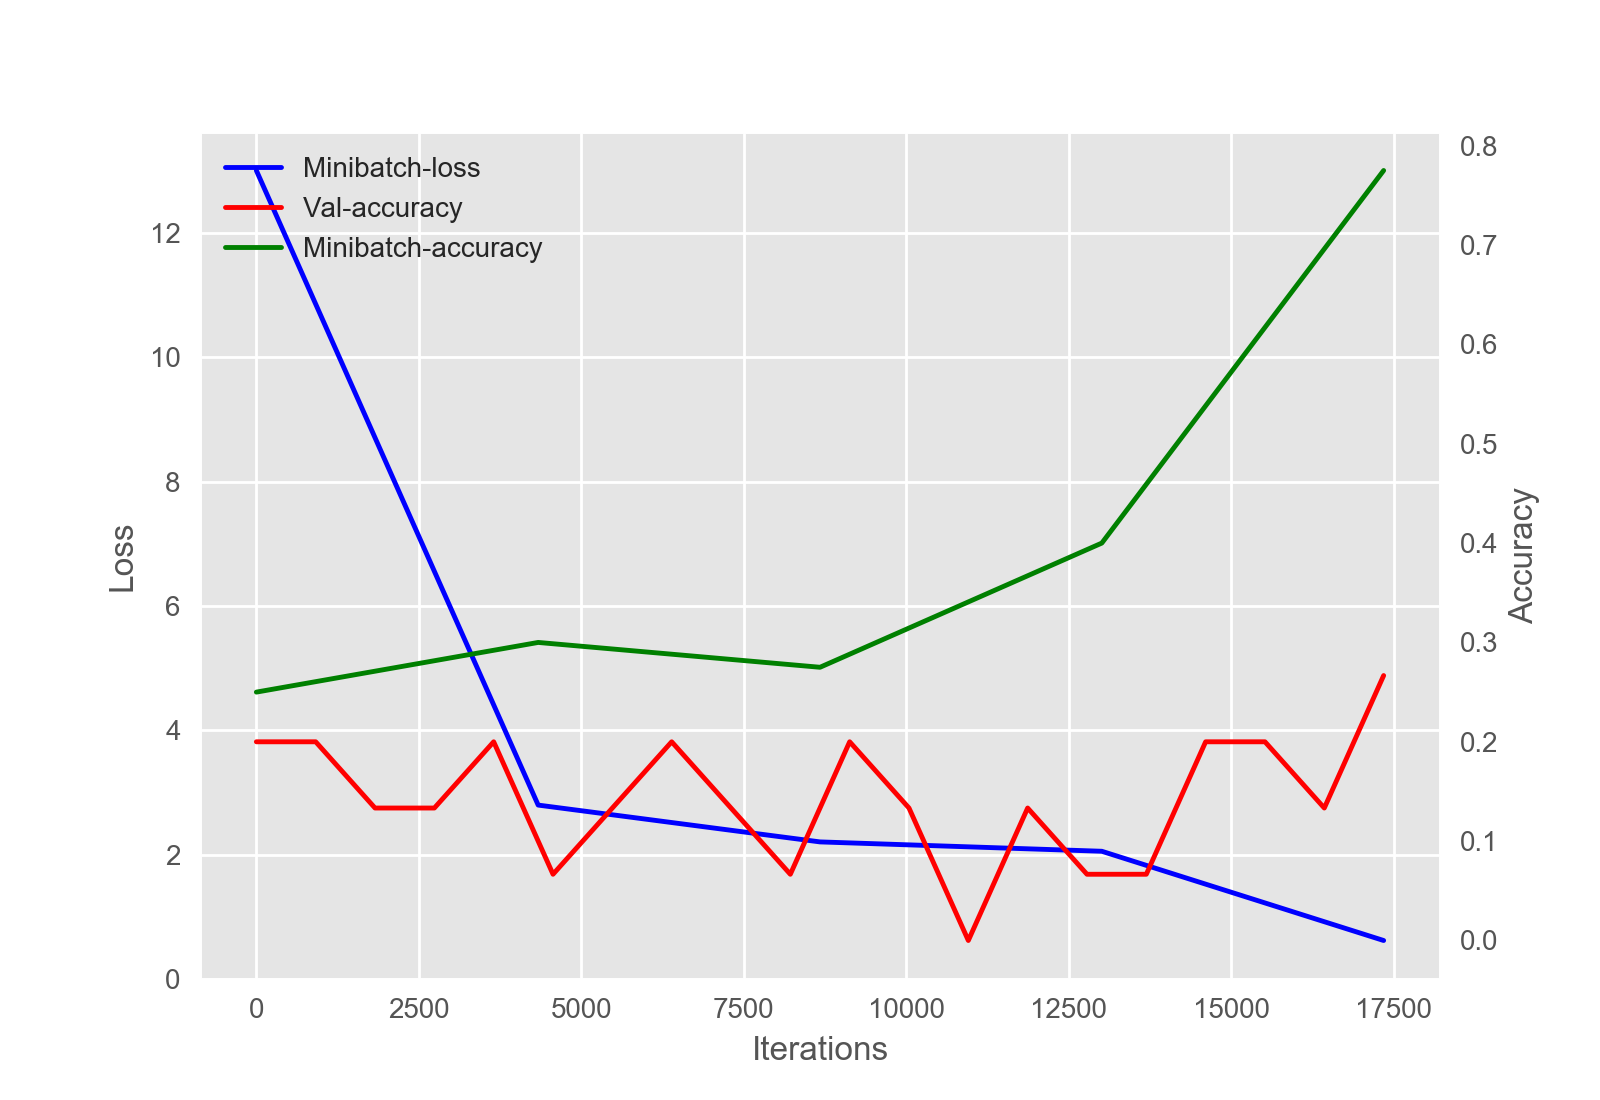

/Users/thein/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/Users/thein/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:12: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


In [46]:
import matplotlib as mpl
#mpl.style("ggplot")
plt.style.use('ggplot')

fig,ax=plt.subplots()
#plt.plot(np.linspace(64,10600,160),np.array(result_dict['Validation accuracy'])/100.0,label='Val-accuracy')
ax.plot(np.linspace(0,17344,length/4),np.mean(np.array(result_dict['Minibatch loss']).reshape(-1,4),1),label='Minibatch-loss',color='b')
#plt.plot(np.linspace(64,10600,160),np.array(result_dict['V loss']),label='Minibatch-loss')
#plt.legend(loc='center right')
ax2=ax.twinx()
ax2.plot(np.linspace(0,17344,length),np.array(result_dict['Validation accuracy'])/100.0,label='Val-accuracy',color='r')
ax2.plot(np.linspace(0,17344,length/4),np.mean(np.array(result_dict['Minibatch accuracy']).reshape(-1,4),1)/100.0,label='Minibatch-accuracy',color='g')
ax.plot(np.nan, '-r', label = 'Val-accuracy')
ax.plot(np.nan, '-g', label = 'Minibatch-accuracy')
ax.legend(loc='upper left')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax2.set_ylabel('Accuracy')
plt.grid(False)
#fig.savefig('Images/2nd_model_accuracy.pdf',transparent=False)

In [47]:
model_list=[i[:-6] for i in glob('2ndmodel_checkpoints_2/*.index')]
model_list

['2ndmodel_checkpoints_2/2stmodel_13_667.0',
 '2ndmodel_checkpoints_2/2stmodel_26_667.0',
 '2ndmodel_checkpoints_2/2stmodel_39_667.0',
 '2ndmodel_checkpoints_2/2stmodel_52_1333.0',
 '2ndmodel_checkpoints_2/2stmodel_65_2000.0',
 '2ndmodel_checkpoints_2/2stmodel_78_1333.0',
 '2ndmodel_checkpoints_2/2stmodel_91_2000.0',
 '2ndmodel_checkpoints_2/2stmodel_104_2667.0',
 '2ndmodel_checkpoints_2/2stmodel_117_667.0',
 '2ndmodel_checkpoints_2/2stmodel_130_1333.0']

In [48]:
total_val_y=np.zeros((len(model_list[:-1]),*test_y.shape))
for count,i in enumerate(model_list[:-1]):
    saver.restore(sess=session,save_path=i)
    total_val_y[count]=session.run(y_pred, feed_dict={x: test_x,dropout:1})

INFO:tensorflow:Restoring parameters from 2ndmodel_checkpoints_2/2stmodel_13_667.0


INFO:tensorflow:Restoring parameters from 2ndmodel_checkpoints_2/2stmodel_13_667.0


INFO:tensorflow:Restoring parameters from 2ndmodel_checkpoints_2/2stmodel_26_667.0


INFO:tensorflow:Restoring parameters from 2ndmodel_checkpoints_2/2stmodel_26_667.0


INFO:tensorflow:Restoring parameters from 2ndmodel_checkpoints_2/2stmodel_39_667.0


INFO:tensorflow:Restoring parameters from 2ndmodel_checkpoints_2/2stmodel_39_667.0


INFO:tensorflow:Restoring parameters from 2ndmodel_checkpoints_2/2stmodel_52_1333.0


INFO:tensorflow:Restoring parameters from 2ndmodel_checkpoints_2/2stmodel_52_1333.0


INFO:tensorflow:Restoring parameters from 2ndmodel_checkpoints_2/2stmodel_65_2000.0


INFO:tensorflow:Restoring parameters from 2ndmodel_checkpoints_2/2stmodel_65_2000.0


INFO:tensorflow:Restoring parameters from 2ndmodel_checkpoints_2/2stmodel_78_1333.0


INFO:tensorflow:Restoring parameters from 2ndmodel_checkpoints_2/2stmodel_78_1333.0


INFO:tensorflow:Restoring parameters from 2ndmodel_checkpoints_2/2stmodel_91_2000.0


INFO:tensorflow:Restoring parameters from 2ndmodel_checkpoints_2/2stmodel_91_2000.0


INFO:tensorflow:Restoring parameters from 2ndmodel_checkpoints_2/2stmodel_104_2667.0


INFO:tensorflow:Restoring parameters from 2ndmodel_checkpoints_2/2stmodel_104_2667.0


INFO:tensorflow:Restoring parameters from 2ndmodel_checkpoints_2/2stmodel_117_667.0


INFO:tensorflow:Restoring parameters from 2ndmodel_checkpoints_2/2stmodel_117_667.0


In [49]:
ens_y=total_val_y[:-1].mean(axis=0)
accuracy(ens_y,test_y)

13.333333333333334

<IPython.core.display.Javascript object>


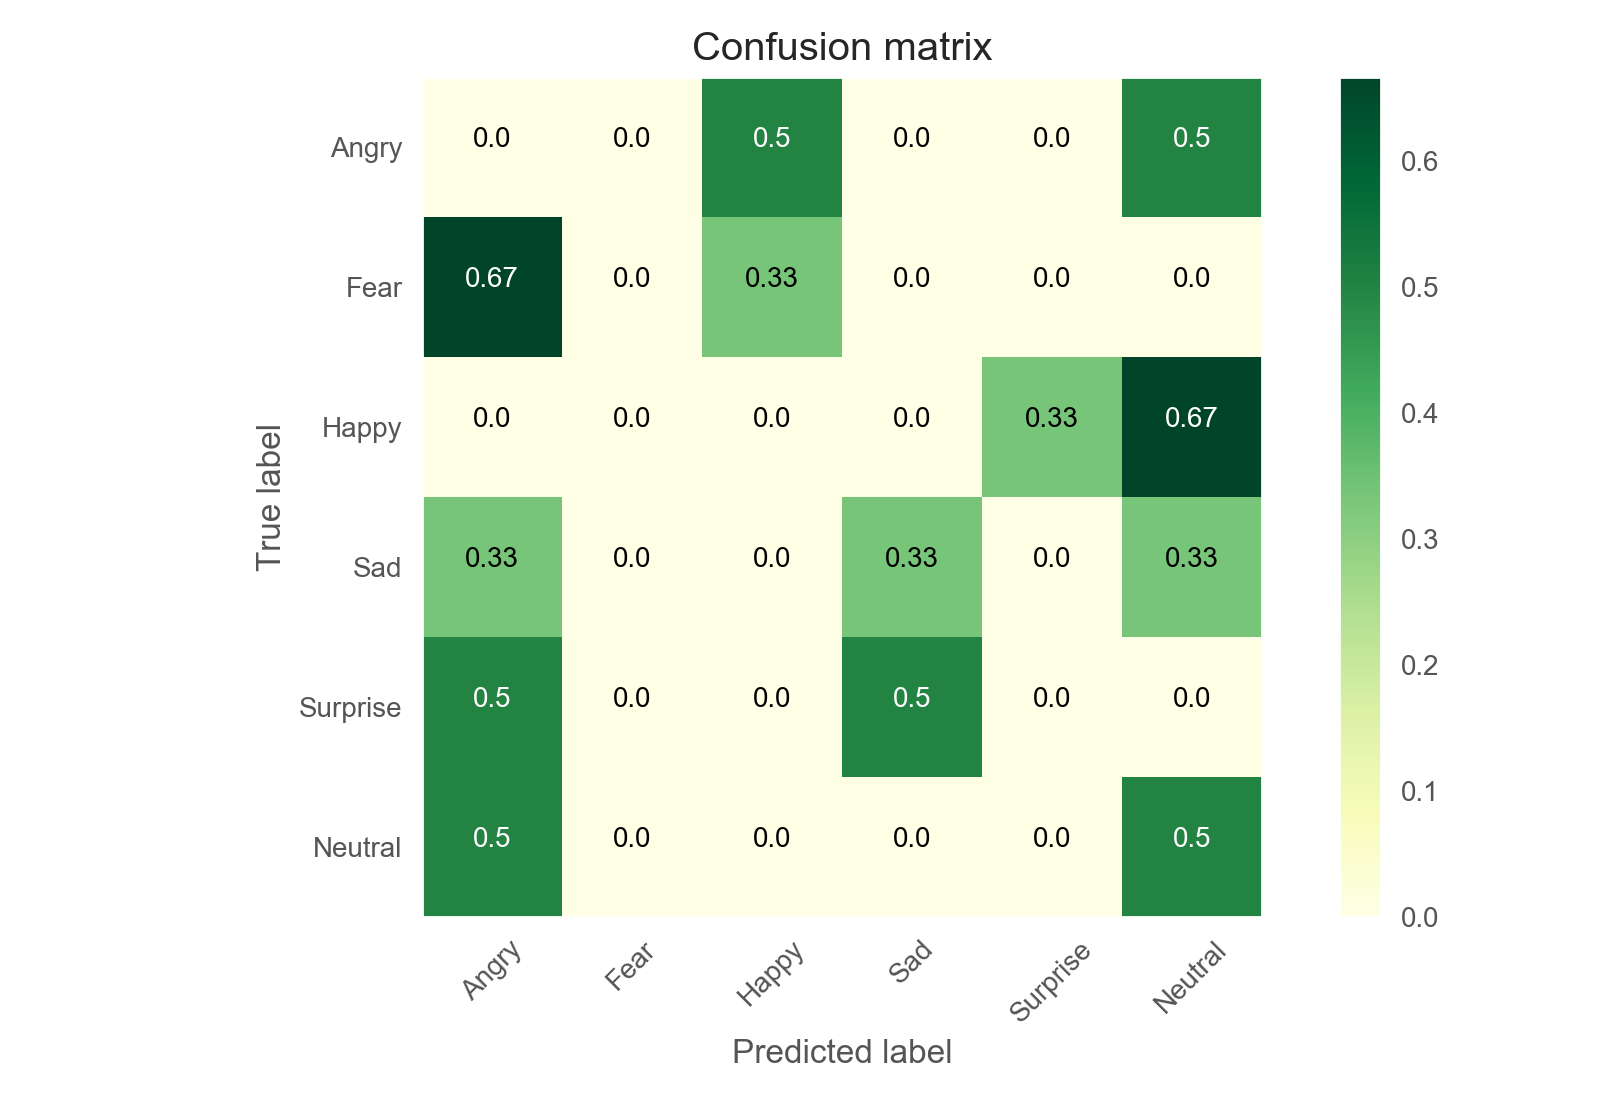

Normalized confusion matrix


In [51]:
plot_confusion_matrix(ens_y,test_y,np.array(list(mod_label_dict.values()))[:,0],\
                     normalize=True)
plt.tight_layout()
#plt.savefig('Images/Ensemble2.png',dpi=900)

In [153]:
6*6*5*5*64*64

3686400

In [159]:
(6*128+128*6*6*64+6*6*64*64*5*5+12*12*64*32*5*5+24*24*1*32*5*5)/1E7

1.181568

In [158]:
(6*128+128*12*12*36+12*12*36*16*5*5+24*24*16*1*5*5)/1E7

0.296832

In [162]:
224*224*64*3*3*3+224*224*64*3*3*64

1936392192

## Plot the wrong prediction images

In [52]:
def plot_images(images, cls_true, cls_pred=None):
    
    #true_label=[mod_label_dict[i][1] for i in np.argmax(cls_true,axis=1)]
    # Create figure with 4x4 sub-plots.
    fig, axes = plt.subplots(3, 3,figsize=(10,10))
    fig.subplots_adjust(hspace=0.4, wspace=0.3)
    if cls_pred is None:
        fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(48,-1), cmap='gray')
        label_color='blue'
        true_=np.argmax(cls_true[i])
        if cls_pred is None:
            xlabel = "{} : {}".format(mod_label_dict[true_][0],mod_label_dict[true_][1])
        else:
            
            pred_=np.argmax(cls_pred[i])
            xlabel = "{0} : {1}".\
            format(mod_label_dict[true_][0], mod_label_dict[pred_][0])
            
    
            if true_ != pred_:
                label_color='red'
        
        ax.set_xlabel(xlabel,color=label_color,fontname='DejaVu Sans',fontsize=20)
        
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
    plt.tight_layout()

    

<IPython.core.display.Javascript object>


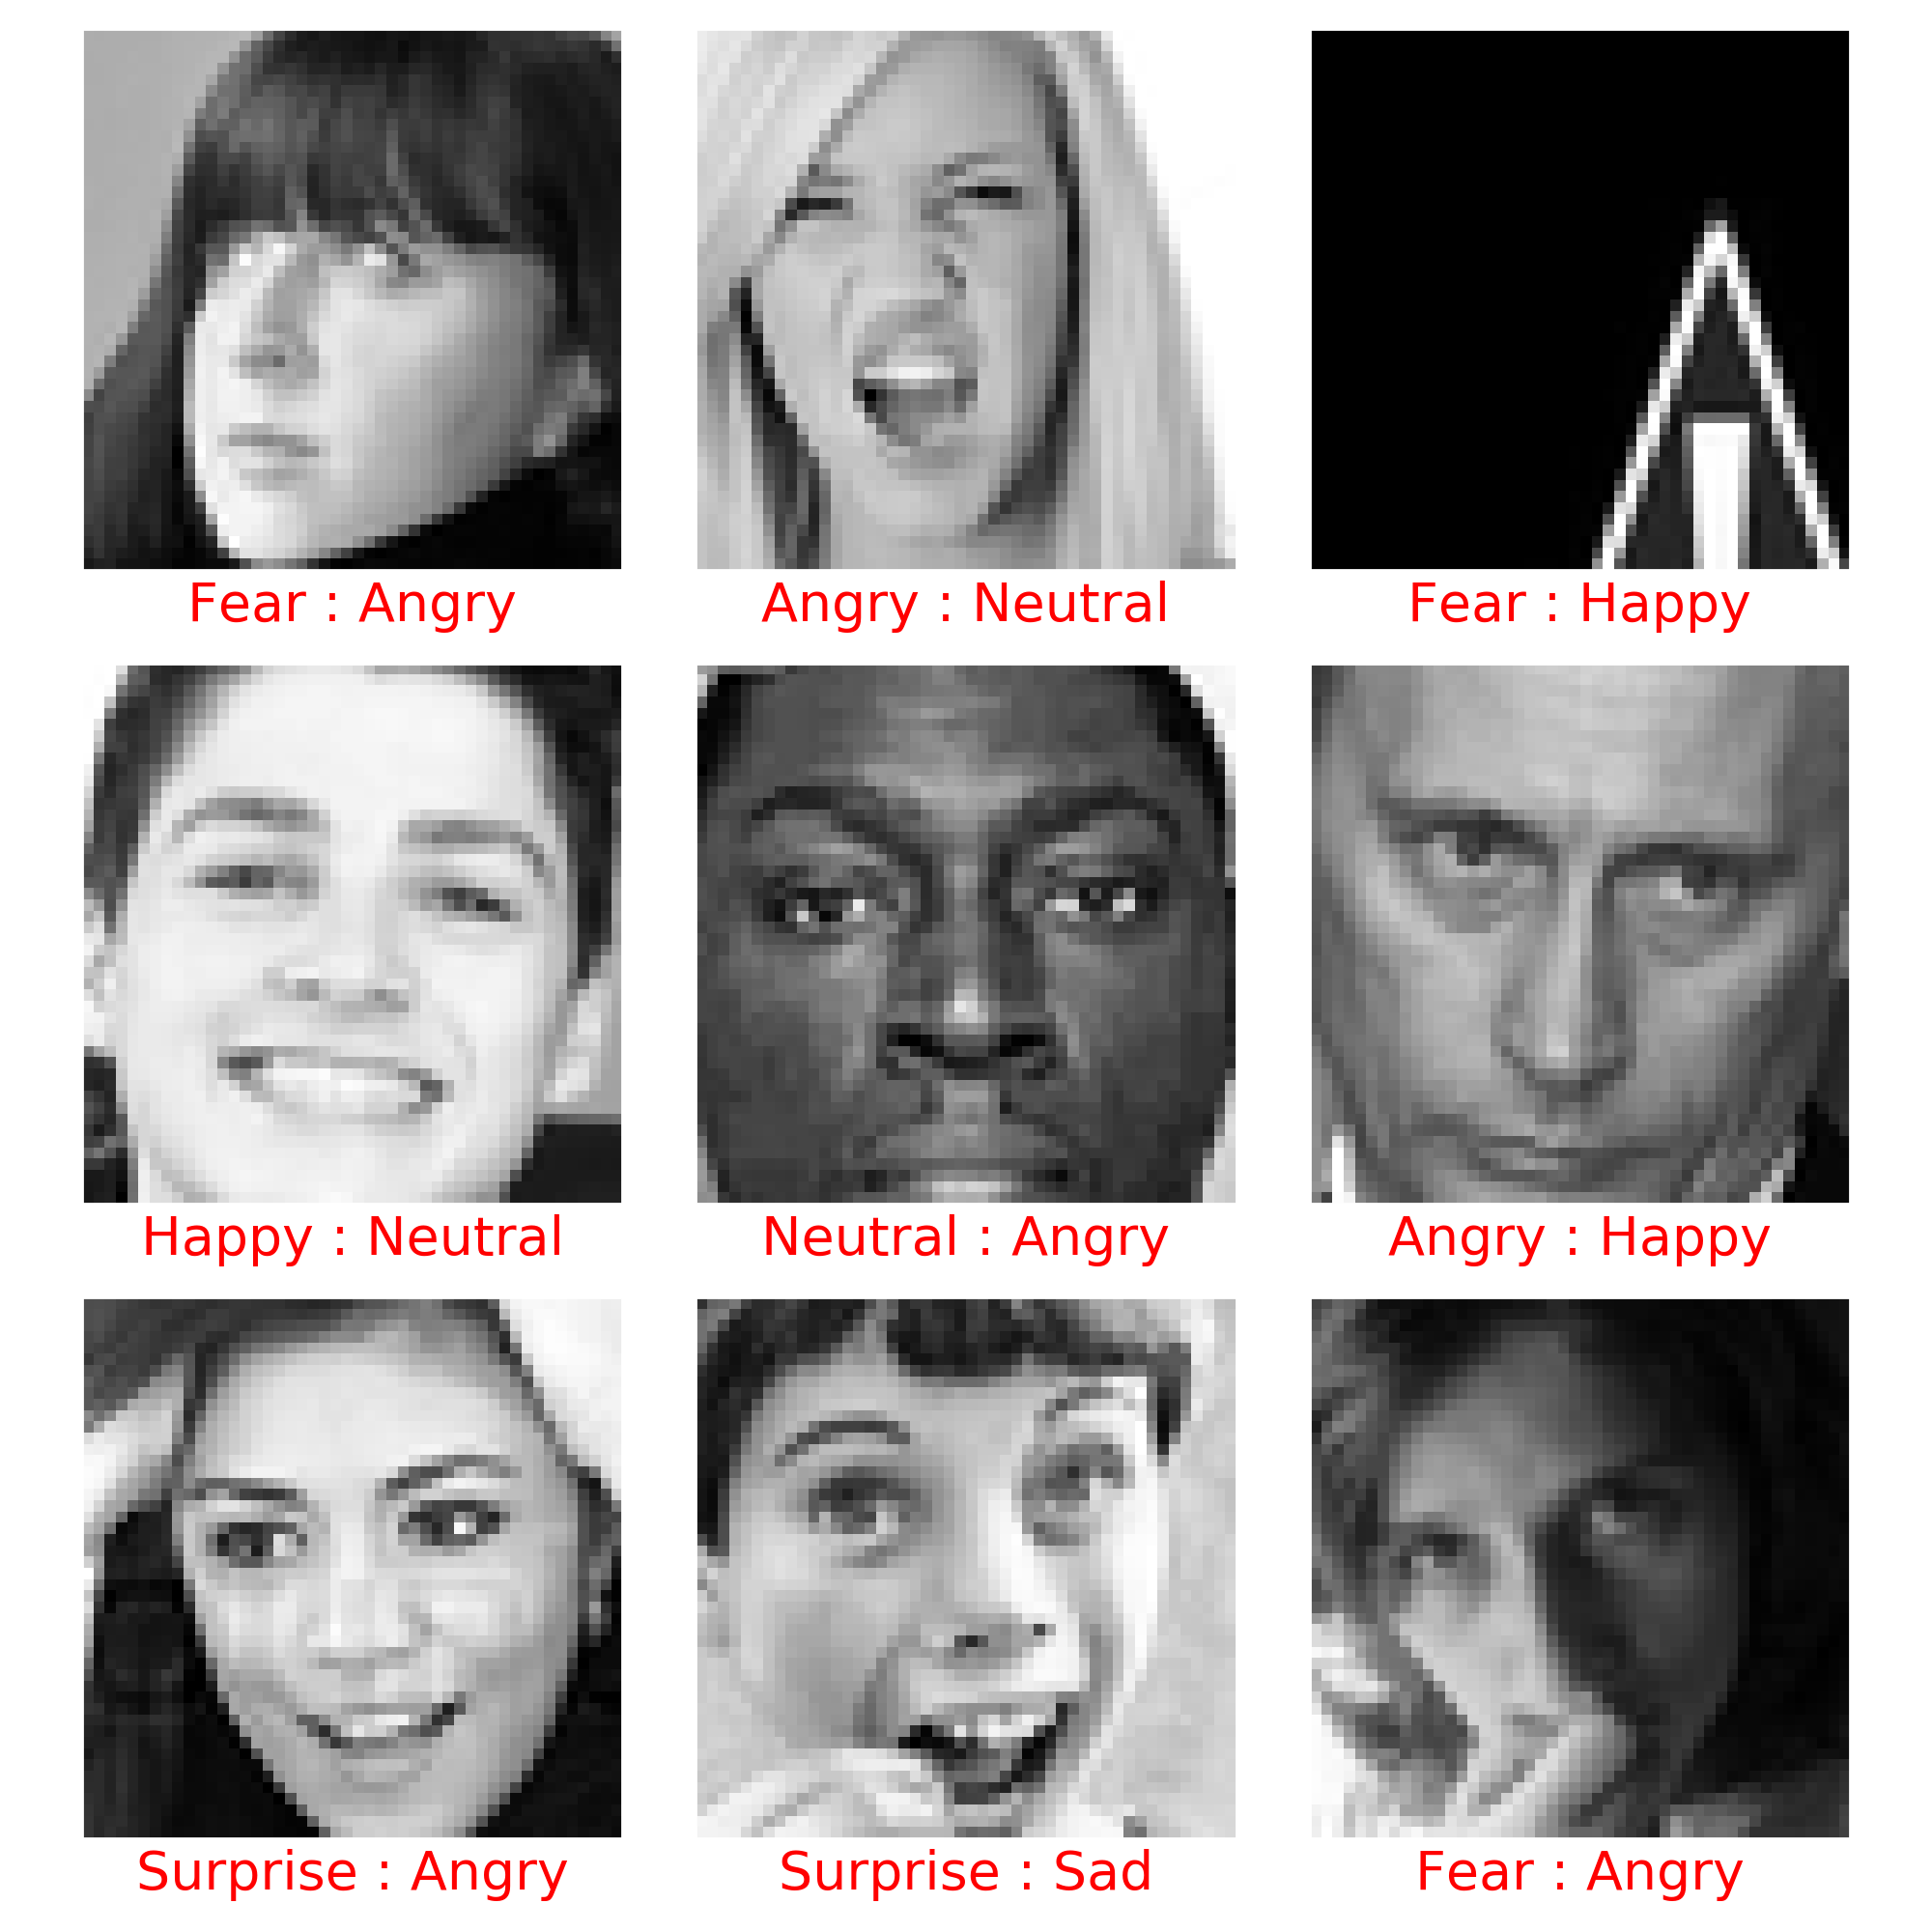

In [54]:
correct=np.argmax(test_y,axis=1) == np.argmax(ens_y,axis=1)
images = test_x[~correct][:16]
cls_true = test_y[~correct][:16]
cls_pred= ens_y[~correct][:16]
plot_images(images=images, cls_true=cls_true,cls_pred=cls_pred)
plt.tight_layout()
#plt.savefig('Images/gitsync/Images/Wrong_prediction.png',dpi=900)